https://github.com/dblilienthal/Multiclass-Text-Classification-with-DistilBERT-on-COVID-19-Tweets/blob/main/Multiclass%20Text%20Classification%20with%20DistilBERT%20on%20COVID-19%20Tweets.ipynb

data 출처 : http://ai.stanford.edu/~amaas/data/sentiment/

In [ ]:
!pip install -U sentence-transformers
!pip install datasets
!pip install gluonnlp pandas tqdm
!pip install mxnet
!pip install transformers

     |████████████████████████████████| 78 kB 3.0 MB/s 
     |████████████████████████████████| 3.4 MB 24.3 MB/s 
     |████████████████████████████████| 6.8 MB 43.1 MB/s 
     |████████████████████████████████| 1.2 MB 49.9 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 3.3 MB 36.8 MB/s 
     |████████████████████████████████| 596 kB 49.4 MB/s 
     |████████████████████████████████| 895 kB 57.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=a78c85939567551e68b81e80546c0a95740480a46cfba5fd42452422cdcfd089
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 306 kB 4.3 MB/s 
     

In [ ]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Progress Bar
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#import transformers
#from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import warnings
#from transformers import logging as hf_logging
#from datasets import load_dataset
import ast
#hf_logging.set_verbosity_error() # Hidding Huggingface Warnings
#warnings.filterwarnings("ignore")

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
MODEL_NAME = 'distilbert-base-cased'

In [ ]:
train_ds,valid_ds, test_ds = load_dataset("emotion",split=["train[:]","validation[:]","test[:]"])

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME) # Loading the tokenizer

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [ ]:
max_val = 0
for sent in (train_ds["text"][:] + train_ds["text"][:] +valid_ds["text"][:]):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 92


In [ ]:
MAX_LENGTH = max_val+2

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH, 
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [ ]:
X_train = tokenize(train_ds["text"][:], tokenizer)
X_test = tokenize(test_ds["text"][:], tokenizer)
X_val = tokenize(valid_ds["text"][:], tokenizer)

100%|██████████| 2000/2000 [00:01<00:00, 1813.07it/s]


In [ ]:
config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(6, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Downloading:   0%|          | 0.00/338M [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 94)]         0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 94)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  65190912   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 94, 768),                                                    
                                 hidden_states=((No                                           

In [ ]:
### Create an output directory
output_dir = '/content/drive/MyDrive/학교 프로젝트/2022 슈퍼챌린지 SW 해커톤/models'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

In [ ]:
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

In [ ]:
y_train=np.asarray(train_ds["label"][:])
y_valid=np.asarray(valid_ds["label"][:])
y_test=np.asarray(test_ds["label"][:])


In [ ]:
y_train.shape

(16000,)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    epochs = 10,
                    batch_size=16, 
                    validation_data=(X_val, y_valid), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/10
1000/1000 [==============================] - 68s 59ms/step - loss: 0.9313 - accuracy: 0.6564 - val_loss: 0.4551 - val_accuracy: 0.8320 - lr: 0.0010
Epoch 2/10
1000/1000 [==============================] - 56s 56ms/step - loss: 0.4230 - accuracy: 0.8478 - val_loss: 0.2890 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 3/10
1000/1000 [==============================] - 55s 55ms/step - loss: 0.2918 - accuracy: 0.8889 - val_loss: 0.2473 - val_accuracy: 0.9090 - lr: 0.0010
Epoch 4/10
1000/1000 [==============================] - 56s 56ms/step - loss: 0.2165 - accuracy: 0.9142 - val_loss: 0.2238 - val_accuracy: 0.9055 - lr: 0.0010
Epoch 5/10
1000/1000 [==============================] - 57s 57ms/step - loss: 0.1730 - accuracy: 0.9306 - val_loss: 0.2065 - val_accuracy: 0.9165 - lr: 0.0010
Epoch 6/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.1483 - accuracy: 0.9387
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1000/1000 [===============

Lowest Validation Loss: epoch 10
Highest Validation Accuracy: epoch 7


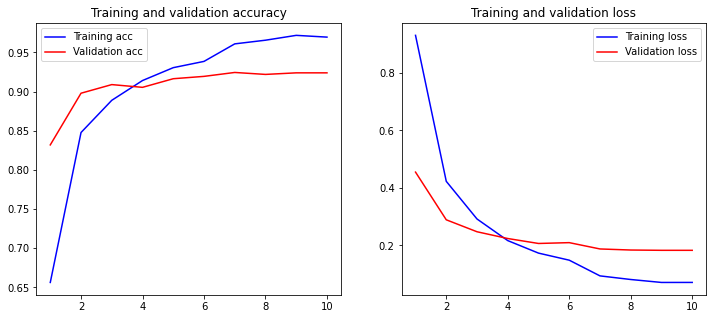

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(history)

In [ ]:
PATH="/content/drive/MyDrive/학교 프로젝트/2022 슈퍼챌린지 SW 해커톤/movie_data"

In [ ]:
neg_sent=pd.read_csv(f"{PATH}/neg_sent.csv",names=["id","text"])
pos_sent=pd.read_csv(f"{PATH}/pos_sent.csv",names=["id","text"])
unsup_sent=pd.read_csv(f"{PATH}/unsup_sent.csv",names=["id","text"]).drop_duplicates(subset=["id"])

In [ ]:
all_data=pd.concat([pd.concat([pos_sent, neg_sent]),unsup_sent])
all_tork=tokenize(list(all_data.text), tokenizer)
all_res=tqdm(model.predict(all_tork))

emotion_dict={}

def emogeLabel(x):
  temp_list=[]
  for emo in x:
    idx=np.argmax(emo)
    if idx==0:
      temp_list.append("sadness")
    elif idx==1:
      temp_list.append("joy")
    elif idx==2:
      temp_list.append("love")
    elif idx==3:
      temp_list.append("anger")
    elif idx==4:
      temp_list.append("fear")
    else:
      temp_list.append("surprise")
  return temp_list

all_emotion=emogeLabel(all_res)
all_data.insert(2,"emotion",all_emotion,True)
print(all_data.head())

100%|██████████| 75000/75000 [06:40<00:00, 187.50it/s]


          id                                               text  emotion
0  tt0453418  Bromwell High is a cartoon comedy. It ran at t...  sadness
1  tt0102303  Homelessness (or Houselessness as George Carli...  sadness
2  tt0102303  Brilliant over-acting by Lesley Ann Warren. Be...    anger
3  tt0102303  This is easily the most underrated film inn th...     fear
4  tt0102303  This is not the typical Mel Brooks film. It wa...      joy


In [ ]:
emotion_dict={}

for id in tqdm(set(all_data.id.values)):
  if id not in emotion_dict.keys():
    emotion_dict[id]=[0,0,0,0,0,0]
    for idx,emo in enumerate(["sadness","joy","love","anger","fear","surprise"]):
      mask = (all_data.id==id) & (all_data.emotion==emo)
      emotion_dict[id][idx]=len(all_data[mask])

all_data=all_data.drop_duplicates(subset=["id"])

100%|██████████| 8481/8481 [06:50<00:00, 20.67it/s]


In [ ]:
def find_my_emotion(x,idx):
  return emotion_dict[x][idx]

all_data["sadness"]=all_data["id"].apply(lambda x: find_my_emotion(x,0))
all_data["joy"]=all_data["id"].apply(lambda x: find_my_emotion(x,1))
all_data["love"]=all_data["id"].apply(lambda x: find_my_emotion(x,2))
all_data["anger"]=all_data["id"].apply(lambda x: find_my_emotion(x,3))
all_data["fear"]=all_data["id"].apply(lambda x: find_my_emotion(x,4))
all_data["surprise"]=all_data["id"].apply(lambda x: find_my_emotion(x,5))

In [ ]:
crew_data=pd.read_csv(f"{PATH}/crew.tsv",sep="\t")

title_data=pd.read_csv(f"{PATH}/title.tsv",sep="\t")
title_data=title_data[title_data.region=="US"]

name_data=pd.read_csv(f"{PATH}/names.tsv",sep="\t")
name_data=name_data[["nconst","primaryName"]]
name_dict=pd.Series(name_data.primaryName.values,index=name_data.nconst).to_dict()


In [ ]:
def make_merge(df):
  df.rename(columns={'id':'tconst'}, inplace=True)
  df=pd.merge(df, crew_data[["tconst","directors"]],how="left")
  df.rename(columns={'tconst':'titleId'}, inplace=True)
  df=pd.merge(df, title_data[["titleId","title"]],how="left")
  return df
all_data=make_merge(all_data)

In [ ]:
all_data=all_data.dropna(axis=0)
all_data=all_data.astype({"directors":"string"})

In [ ]:
def director_naming(x):
  res=""
  if len(x.split(","))!=1:
    for dir in x.split(","):
      res+=name_dict[dir]
    return res
  else:
    if x not in name_dict.keys():
      return np.NAN
    return name_dict[x]

all_data["directors"]=all_data["directors"].apply(director_naming)
all_data=all_data.dropna(axis=0)

In [ ]:
all_data

,titleId,text,emotion,sadness,joy,love,anger,fear,surprise,directors,title
1,tt0102303,Homelessness (or Houselessness as George Carli...,sadness,1,4,0,2,2,4,Mel Brooks,Life Sucks
2,tt0102303,Homelessness (or Houselessness as George Carli...,sadness,1,4,0,2,2,4,Mel Brooks,Life Stinks
3,tt0448075,"This isn't the comedic Robin Williams, nor is ...",anger,1,6,1,4,4,0,Patrick Stettner,The Night Listener
4,tt0211938,I liked the film. Some of the action scenes we...,surprise,1,2,0,5,2,9,Antoine Fuqua,Bait
5,tt0063097,The legendary Boris Karloff ended his illustri...,anger,0,0,0,2,0,0,Juan IbáñezJack Hill,House of Evil
...,...,...,...,...,...,...,...,...,...,...,...
11762,tt0492486,This is one of the worst films I have ever see...,anger,2,3,0,12,6,2,Paddy Breathnach,Shrooms
11763,tt0861701,"I sat down to watch this movie, with my brothe...",fear,0,1,0,1,1,0,Gary Ugarek,Deadlands
11764,tt0861701,"I sat down to watch this movie, with my brothe...",fear,0,1,0,1,1,0,Gary Ugarek,Zombie Genocide: Legion of the Damned
11765,tt0861701,"I sat down to watch this movie, with my brothe...",fear,0,1,0,1,1,0,Gary Ugarek,Deadlands: The Rising


In [ ]:
def make_10_list(emotion):
  max_cnt=all_data.sort_values(by=emotion,ascending=False).iloc[0][emotion]
  temp_data=all_data.loc[all_data[emotion]>=max_cnt,["title","directors"]]
  while(len(temp_data)<10):
    max_cnt-=1
    temp_data=all_data.loc[all_data[emotion]>=max_cnt,["title","directors"]]
  return temp_data

for emotion in ["sadness","joy","love","anger","fear","surprise"]:
  make_100_list(emotion).to_csv(f"{PATH}/{emotion}.txt",index=False,header=False)